# Project: 다양한 OCR 모델 비교하기
- OCR

## 1. 서비스 기획
#### 표지판/간판 OCR
- TTS 기술을 결합하여 시각장애인에게 표지판 및 간판을 알려줄 수 있을 것이다.
- 번역 기술을 결합하여 영어를 모르는 외국인 관광객에게 도움을 줄 수 있을 것이다.

### 평가 기준
- 정면에서 찍힌 것을 잘 인식하는가
- 기울여서 찍힌 것을 잘 인식하는가
- 글씨 크기에 관계 없이 잘 인식하는가
- 일부가 그림자 진 경우에도 잘 인식하는가
- 글씨가 일부 훼손된 경우에도 잘 인식하는가

해당 평가 기준의 특징을 반영한 간판/표지판 이미지 4가지를 준비하였다.

## 2. OCR 모델 비교

In [6]:
# 라이브러리 불러오기
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import keras_ocr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# 이미지 확인
img_path = "./data"
img_list = os.listdir(img_path)
img_list

['super-duper.jpg',
 '1-funny-signs.jpg',
 '다운로드.jpg',
 'thumb_d_55CD5C9BCBB8A5713455F17ED740EBA1.jpg']

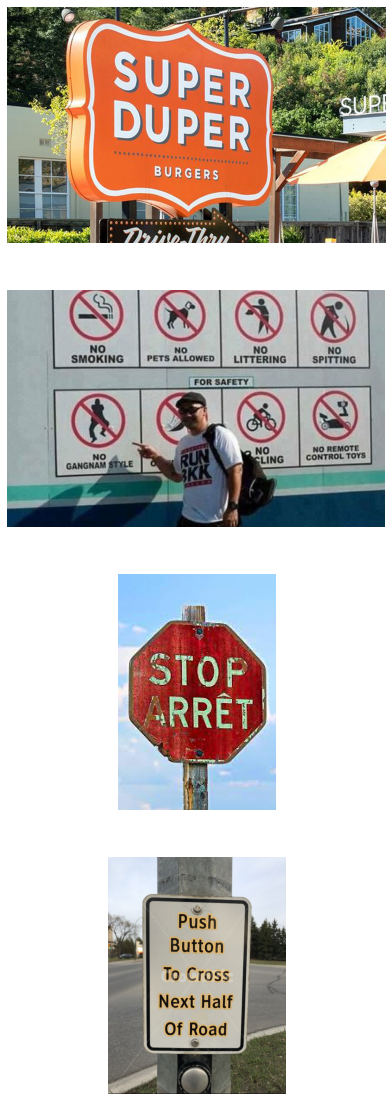

In [16]:
# 원본 이미지
fig, axs = plt.subplots(nrows=len(img_list), figsize=(20, 20))
for i, ax in enumerate(axs):
    image = Image.open(os.path.join(img_path, img_list[i]))
    ax.imshow(image)
    ax.axis("off")

plt.show()

### 1) keras-ocr

In [7]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [8]:
images = [keras_ocr.tools.read(os.path.join(img_path, img)) for img in img_list]
prediction_groups = [pipeline.recognize([os.path.join(img_path, img)]) for img in img_list]

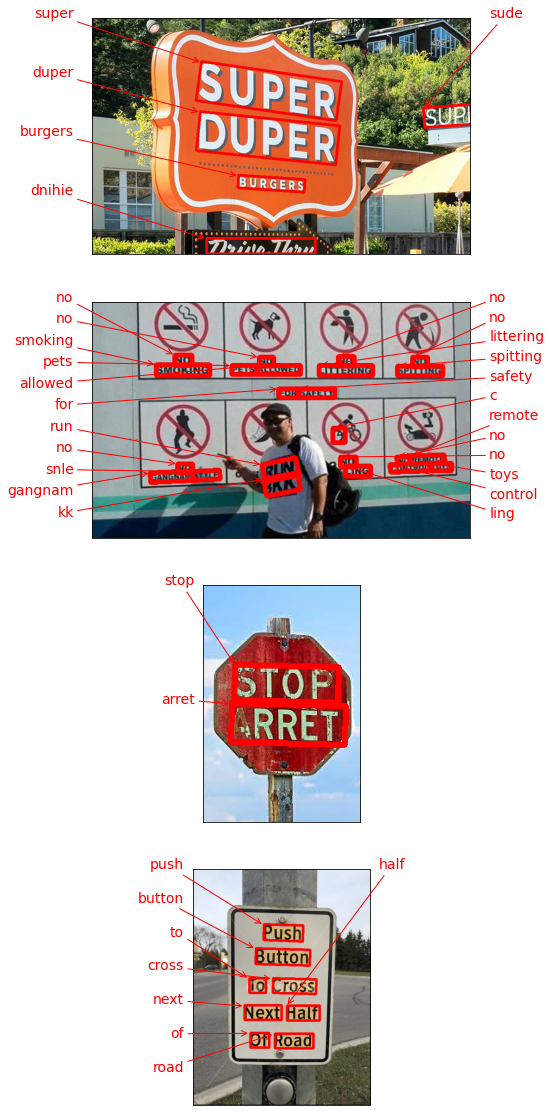

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2) tesseract

In [28]:
def recognize_images(image_path, output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
            
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")
    print()

In [29]:
for img in img_list:
    print(f"[{img}]")
    try:
        recognize_images(os.path.join(img_path, img))
    except Exception:
        print(f"Recognition failed from {img}")
        print()

[super-duper.jpg]
eC



aa



SUPER

ER

DUPER

BURGERS

Done

[1-funny-signs.jpg]
| SS) | @ | @)|

bee Masarcegem! | an pees ec



R

NO

NO

SMOKING

SPITTING


NO


CONTROL


Done

[다운로드.jpg]

Done

[thumb_d_55CD5C9BCBB8A5713455F17ED740EBA1.jpg]

Done



### 3) 결과 비교

|평가기준|keras-ocr|tesseract|
|------|---|---|
|정면에서 찍힌 것을 잘 인식하는가|O|△|
|기울여서 찍힌 것을 잘 인식하는가|△|X|
|글씨 크기에 관계 없이 잘 인식하는가|O|△|
|일부가 그림자 진 경우에도 잘 인식하는가|△|X|
|글씨가 일부 훼손된 경우에도 잘 인식하는가|O|X|

keras-ocr이 tesseract보다 훨씬 낫다.

## 회고

- captcha를 인식하기 위해 tesseract를 opencv와 함께 사용한 적이 있었다. 이때 성능은 꽤 괜찮았는데, captcha 이미지보다 인식이 더 쉬울 것 같은 표지판/간판 글씨를 잘 인식하지 못하는 게 좀 의외였다. opencv를 결합해서 사용하면 성능이 나아질 수도 있을 것이라는 생각이 들었다.
- keras-ocr은 처음 사용해봤는데 생각보다 성능이 좋아서 놀랐다. 